In [1]:
import os
import numpy as np

# anns_folder = '/dfs/scratch0/paroma/coco/annotations/'
anns_folder = os.environ['SNORKELHOME'] + '/tutorials/babble/drink/data/'
train_path = anns_folder + 'drink_train_anns.npy'
val_path = anns_folder + 'drink_val_anns.npy'

train_anns = np.load(train_path).tolist()
val_anns = np.load(val_path).tolist()

In [2]:
import os

DOMAIN = 'drink'
DB = 'postgres'

if DB == 'postgres':
    db_dict = {
        'test':   'postgres:///babble_model_unittest',
        'spouse': 'postgres:///babble_model_spouse',
        'bike':   'postgres:///babble_model_bike',
        'drink':   'postgres:///babble_model_drink',
        'cdr':    'postgres:///babble_model_cdr',
    }
    os.environ['SNORKELDB'] = db_dict[DOMAIN]
    
elif DB == 'sqlite':
    #os.remove('snorkel.db')
    import shutil
    shutil.copy2('bike/snorkel.db', './')

In [3]:
from snorkel.contrib.babble.pipelines import config

config = configuration
config['domain'] = DOMAIN
config['splits'] = [0,1]
config['babbler_split'] = 0
config['max_docs'] = None
config['parallelism'] = 1
config['traditional'] = False
config['majority'] = False
config['verbose'] = True
config['display_marginals'] = False
config['display_accuracies'] = True
config['display_learned_accuracies'] = True

In [11]:
from snorkel.models import candidate_subclass
from tutorials.babble import MTurkHelper
from snorkel.contrib.babble import ExplanationIO

if DOMAIN == 'spouse':
    from tutorials.babble.spouse import SpousePipeline
    Spouse = candidate_subclass('Spouse', ['person1', 'person2'])
    candidate_class = Spouse
    
    expio = ExplanationIO()
    fpath = (os.environ['SNORKELHOME'] + 
        '/tutorials/babble/spouse/data/mturk_explanations_all.tsv')
    explanations = expio.read(fpath)
    
    sm = SpousePipeline(session, Spouse, config)
elif DOMAIN == 'bike':
    from tutorials.babble.bike import BikePipeline
    Biker = candidate_subclass('Biker', ['person', 'bike'])
    candidate_class = Biker
    
    helper = MTurkHelper()
    output_csv_path = (os.environ['SNORKELHOME'] + 
                       '/tutorials/babble/bike/data/VisualGenome_all_out.csv')
    explanations = helper.postprocess_visual(output_csv_path, set_name='train', verbose=False)
    
    sm = BikePipeline(session, Biker, config)    
else:
    raise Exception('Invalid domain: {}'.format(DOMAIN))
user_lists = {}
print("Total explanations: {}".format(len(explanations)))

Reading train CSV!
Num HITs unique: 40
Num HITs total: 120
Unanimous: 99
Majority: 33
Bad: 27
Total explanations: 367


In [3]:
from snorkel import SnorkelSession
session = SnorkelSession()

In [4]:
from snorkel.annotations import load_gold_labels

L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_dev

<495x1 sparse matrix of type '<type 'numpy.int64'>'
	with 411 stored elements in Compressed Sparse Row format>

In [13]:
import numpy as np
np.shape(np.where(np.array(L_gold_dev) == 1))[1]

145

In [14]:
from snorkel.annotations import load_gold_labels

L_gold_train = load_gold_labels(session, annotator_name='gold', split=0)
L_gold_train

<2406x1 sparse matrix of type '<type 'numpy.int64'>'
	with 2102 stored elements in Compressed Sparse Row format>

In [15]:
train_marginals = np.load('../train_marginals.npy')

### Making CSV for Payal

In [6]:
train_mscoco = np.load(anns_folder+'drink_train_mscoco.npy')
val_mscoco = np.load(anns_folder+'drink_val_mscoco.npy')

In [10]:
from snorkel.models import candidate_subclass
from tutorials.babble.drink import DrinkPipeline
Drinker = candidate_subclass('Drinker', ['person', 'cup'])

In [11]:
candidates = session.query(Drinker).filter(Drinker.split == 1).all()
L_gold_dev = np.array(L_gold_dev.todense())

In [14]:
num_candidates = len(candidates)

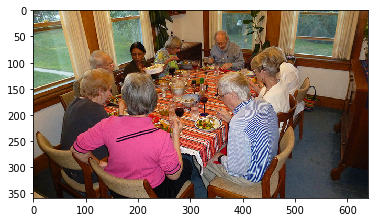

In [16]:
import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline

c = candidates[0]
I = io.imread('http://mscoco.org/images/'+str(train_mscoco[int(c.cup.stable_id.split(":")[1])]))
plt.imshow(I)

In [17]:
coco_ids =  np.zeros(len(val_anns))
labels = np.zeros(len(val_anns))

for idx in range(num_candidates):
    cand = candidates[idx]
    image_id = int(cand.cup.stable_id.split(":")[1])
    mscoco_id = val_mscoco[image_id]

    import pdb
    if mscoco_id == 0:
        pdb.set_trace()
    coco_ids[image_id] = int(mscoco_id)

    label = L_gold_dev[idx]
    if label == 1: #only record true
        labels[image_id] = 1

In [25]:
np.shape(np.where(labels == 1))[1]/float(len(labels))

0.44387755102040816

In [21]:
import csv
with open('train_marginal_images.csv', 'w') as csvfile:
    csvwriter = csv.writer(csvfile)
    
    for idx in range(len(coco_ids)):
        if coco_ids[idx] == 0:
            continue
        else:
            csvwriter.writerow(['http://mscoco.org/images/'+str(int(coco_ids[idx])),
                                labels[idx]])